# Tensors
## ALSCP

In [52]:
import numpy as np
import tensorly as tl
import scipy.io as sio
from tensorly.decomposition import parafac, tucker
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
data = sio.loadmat("data/claus.mat")
X = data['X']
print(X.shape)

(5, 201, 61)


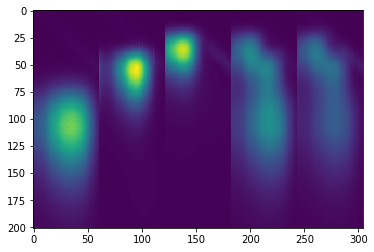

In [57]:
plt.imshow(tl.unfold(X, 1))

In [36]:
ys = tl.unfold(X, 2)
ys.shape

(61, 1005)

In [58]:
factors = tl.decomposition.parafac(X, rank=2)

In [59]:
core, factors = tl.decomposition.tucker(X, ranks=[3, 10, 3])

In [233]:
def model(factors, shape):
    M0 = factors[0] @ tl.tenalg.khatri_rao(factors, skip_matrix=0).T
    return tl.fold(M0, 0, shape)

In [267]:
def ALSCP(tensor, r, iters=5, tol=1e-5, normalize = False):
    d = len(tensor.shape)
    A = [np.random.rand(nk, r) for nk in [*tensor.shape]]
    Grams = [X.T @ X for X in A]
    lambdas = [np.zeros((X.shape[1])) for X in A]
    fit = 0.0
    fitnesses = []
    for i in range(iters):
        oldfit = fit
        for k in range(d):
            B = tl.unfold(tensor, k) @ tl.tenalg.khatri_rao(A, skip_matrix=k)
            V = np.multiply.reduce(Grams[0:k] + Grams[k+1:])
            A[k] = np.linalg.solve(V, B.T).T
            if normalize:  
                for j in range(A[k].shape[1]):
                    lambdas[k][j] = np.linalg.norm(A[k][:, j])
                    A[k][: j] /= lambdas[k][j]
            Grams[k] = A[k].T @ A[k]
        M = model(A, tensor.shape)
        fit = 1.0 - tl.norm(X - M) / tl.norm(X)
        fitnesses.append(fit)
        if abs(fit - oldfit) < tol:
            break
    # [A[k] * lambdas[k] for k in range(d)]
    return A, fitnesses

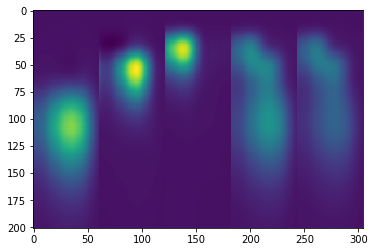

In [268]:
factors, fitnesses = ALSCP(X, 3, 10, normalize=False)
# plt.imshow(tl.unfold(X - model(factors, X.shape), 1))
plt.imshow(tl.unfold(model(factors, X.shape), 1))

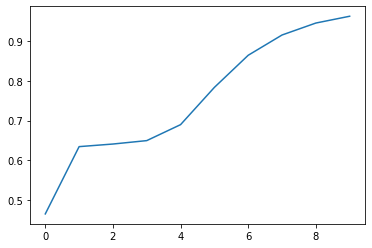

In [271]:
plt.plot(fitnesses)

## Determining the rank

Rank 2
Rank 4


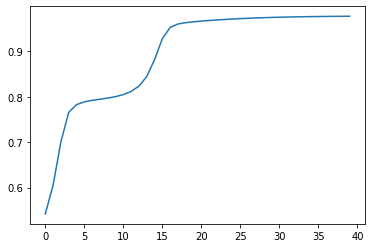

In [277]:
print("Rank 2")
factors, fitnesses2 = ALSCP(X, 2, 10, normalize=False)

print("Rank 4")
factors, fitnesses4 = ALSCP(X, 4, 40, normalize=False)

plt.plot(fitnesses4)